In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2

import numpy as np

In [3]:
tmp = cv2.imread('/mnt/c/Users/Asus/OneDrive/Desktop/LandUseRight_OCR/experimenting/sample/savedImage.jpg')
print(tmp.shape)
tmp

(133, 227, 3)


array([[[201, 209, 216],
        [185, 193, 200],
        [191, 199, 206],
        ...,
        [197, 206, 210],
        [209, 218, 222],
        [206, 215, 219]],

       [[212, 220, 227],
        [192, 200, 207],
        [188, 196, 203],
        ...,
        [205, 214, 218],
        [212, 221, 225],
        [210, 219, 223]],

       [[219, 225, 230],
        [207, 213, 218],
        [192, 200, 207],
        ...,
        [200, 209, 213],
        [204, 213, 217],
        [203, 212, 216]],

       ...,

       [[208, 218, 225],
        [207, 217, 224],
        [215, 222, 231],
        ...,
        [215, 224, 228],
        [215, 224, 227],
        [209, 218, 221]],

       [[210, 220, 227],
        [201, 211, 218],
        [214, 221, 230],
        ...,
        [217, 226, 230],
        [212, 221, 224],
        [203, 212, 215]],

       [[214, 225, 229],
        [202, 213, 217],
        [213, 221, 228],
        ...,
        [220, 229, 233],
        [220, 229, 232],
        [221, 230, 233]]

In [12]:
class processImg:

  def __init__(self, img_path:str):
    self.image = cv2.imread(img_path)
    self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    self.inverted_image = cv2.bitwise_not(self.thresholded_image)
    self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=1) # chỉnh iteration

  # def convert_image_to_grayscale(self): # chuyển xám
  #     self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
  #     return self.grayscale_image

  # def threshold_image(self): #giữ pixel trắng và xám
  #     self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  #     return self.thresholded_image

  # def invert_image(self):
  #     self.inverted_image = cv2.bitwise_not(self.thresholded_image)
  #     return self.inverted_image

  # def dilate_image(self):
  #     self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=1) # chỉnh iteration
  #     return self.dilated_image

  def order_points(self, pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

  def find_contours(self):
    contours, hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # gray = process_img.convert_image_to_grayscale()
    # image_with_all_contours = gray.copy()
    # cv2.drawContours(image_with_all_contours, contours, -1, (0, 255, 0), 3)
    return contours, hierarchy

  def rec_contour(self):
    contours, hierarchy = self.find_contours()
    rectangular_contours = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            rectangular_contours.append(approx)
    # image_with_only_rectangular_contours = self.grayscale_image.copy()
    # rec_cont = cv2.drawContours(image_with_only_rectangular_contours, rectangular_contours, -1, (0, 255, 0), 3)
    return rectangular_contours

  def find_MaxContour(self):
    max_area = 0
    contour_with_max_area = None
    rectangular_contours = self.rec_contour()
    for contour in rectangular_contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            contour_with_max_area = contour
    # image_with_contour_with_max_area = gray.copy()
    # cv2.drawContours(image_with_contour_with_max_area, [contour_with_max_area], -1, (0, 255, 0), 3)
    return contour_with_max_area

  def calculateDistanceBetween2Points(self, p1, p2):
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

  def angle_points(self):
    contour_with_max_area = self.find_MaxContour()
    contour_with_max_area_ordered = self.order_points(contour_with_max_area)
    # image_with_points_plotted = self.grayscale_image.copy()
    # for point in contour_with_max_area_ordered:
    #     point_coordinates = (int(point[0]), int(point[1]))
    #     image_with_points_plotted = cv2.circle(image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)
    return contour_with_max_area_ordered

  def calculate_new_image_size(self):
    existing_image_width = self.grayscale_image.shape[1]
    contour_with_max_area_ordered = self.angle_points()
    existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
    distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[1])
    distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[3])
    aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
    new_image_width = existing_image_width_reduced_by_10_percent
    new_image_height = int(new_image_width * aspect_ratio)
    return new_image_width, new_image_height

  def new_padded_perspective(self):
    contour_with_max_area_ordered = self.angle_points()
    new_image_width, new_image_height = self.calculate_new_image_size()
    pts1 = np.float32(contour_with_max_area_ordered)
    pts2 = np.float32([[0, 0], [new_image_width, 0], [new_image_width, new_image_height], [0, new_image_height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    perspective_corrected_image = cv2.warpPerspective(self.grayscale_image, matrix, (new_image_width, new_image_height))
    image_height = self.grayscale_image.shape[0]
    padding = int(image_height * 0.1)
    perspective_corrected_image_padded = cv2.copyMakeBorder(perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return perspective_corrected_image_padded

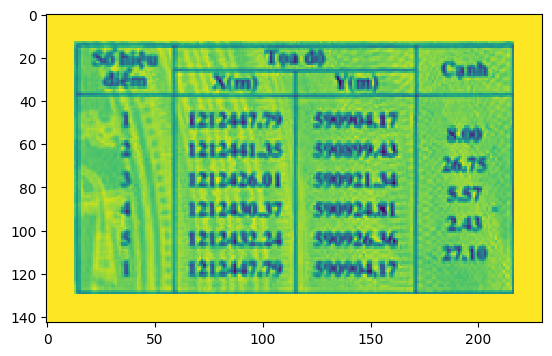

In [18]:
image = '/mnt/c/Users/Asus/OneDrive/Desktop/LandUseRight_OCR/experimenting/sample/savedImage.jpg'
process_img = processImg(image)
plt.imshow(process_img.new_padded_perspective(), interpolation='nearest')
plt.show()

In [13]:
class linesRemover:
  def __init__(self, image:processImg):
    self.processed_obj = image
    self.perpective_padded = self.processed_obj.new_padded_perspective()
    self.thresh_tb = cv2.threshold(self.perpective_padded, 180, 255, cv2.THRESH_BINARY)[1]
    self.invert_tb = cv2.bitwise_not(self.thresh_tb)

  def get_horizontal(self):
    hor = np.array([[1,1,1,1,1,1]])
    vertical_lines_eroded_image = cv2.erode(self.invert_tb, hor, iterations=6)
    vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=15)
    return vertical_lines_eroded_image

  def get_vertical(self):
    ver = np.array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
    horizontal_lines_eroded_image = cv2.erode(self.invert_tb, ver, iterations=2)
    horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=5)
    return horizontal_lines_eroded_image

  def subtract_line(self):
    combined_image = cv2.add(self.get_horizontal(), self.get_vertical())
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=2)
    image_without_lines = cv2.subtract(self.invert_tb, combined_image_dilated)
    return image_without_lines

  def denoise_img(self):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(self.subtract_line(), kernel, iterations=1)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)
    return image_without_lines_noise_removed


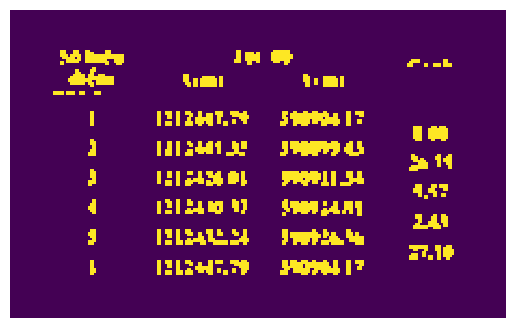

In [19]:
rmline = linesRemover(process_img)

plt.imshow(rmline.denoise_img(), interpolation='nearest')
plt.axis('off')
plt.show()

In [14]:
class TableProcess:
  def __init__(self, image:linesRemover):
    self.lineRm = image
    self.image_without_lines = self.lineRm.denoise_img()
    
  def dilated(self):
    kernel_to_remove_gaps_between_words = np.array([
            [1,1],
            [1,1]
    ])
    dilated_image = cv2.dilate(self.image_without_lines, kernel_to_remove_gaps_between_words, iterations=1)
    simple_kernel = np.ones((5,5), np.uint8)
    dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=1)
    return dilated_image

  def drawBox(self): #trả về x, y,w,h của box chứa nội dung
    result = cv2.findContours(self.dilated(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]
    # image_with_contours_drawn = grey_tb.copy()
    # cv2.drawContours(image_with_contours_drawn, contours, -1, (0, 255, 0), 1)
    bounding_boxes = []
    # image_with_all_bounding_boxes = process_img.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
        # image_with_all_bounding_boxes = cv2.rectangle(image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    bounding_boxes.sort(key = lambda x: x[0])
    
    return bounding_boxes

  # def croppedImg(self):
  #   bounding_boxes = self.drawBox()
  #   cropped_image = image[y:y+h, x:x+w]
  #   for idx, i in enumerate(bounding_boxes):
  #     cropped = display_img(grey_tb, i[0], i[1], i[2], i[3])
  #     # cropped_image_path = os.path.join(save_dir, f'table_{idx + 1}.jpg')
  #     cv2.imwrite(cropped_image_path, cropped)
  #     plt.imshow(cropped, cmap = 'gray')



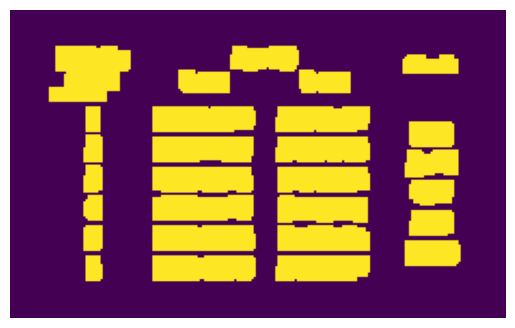

In [20]:
ans = TableProcess(rmline)

plt.imshow(ans.dilated())
plt.axis('off')
plt.show()

In [27]:
image = '/mnt/c/Users/Asus/OneDrive/Desktop/LandUseRight_OCR/experimenting/sample/savedImage.jpg'


process_img = processImg(image)

rmline = linesRemover(process_img)

ans = TableProcess(rmline)
boxes = ans.drawBox()
boxes

[(18, 17, 38, 26),
 (34, 100, 9, 12),
 (34, 86, 9, 12),
 (34, 72, 9, 13),
 (34, 58, 9, 13),
 (35, 114, 8, 12),
 (35, 45, 7, 12),
 (66, 114, 48, 12),
 (66, 100, 48, 12),
 (66, 86, 47, 12),
 (66, 73, 47, 12),
 (66, 59, 47, 12),
 (66, 45, 48, 12),
 (78, 28, 24, 11),
 (102, 17, 32, 12),
 (123, 114, 44, 12),
 (123, 59, 44, 12),
 (123, 45, 44, 12),
 (124, 100, 43, 12),
 (124, 86, 42, 13),
 (124, 73, 43, 12),
 (134, 28, 24, 11),
 (182, 21, 26, 9),
 (183, 107, 26, 12),
 (183, 65, 25, 13),
 (185, 93, 21, 12),
 (185, 79, 21, 12),
 (185, 52, 21, 12)]

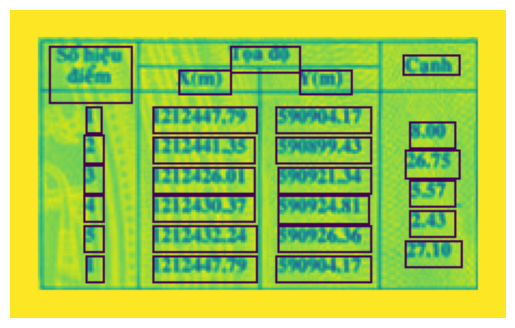

In [32]:
# def display_img(image, x, y, w, h):
#   cropped_image = image[y:y+h, x:x+w]
  
#   return cropped_image

image_with_all_bounding_boxes = process_img.new_padded_perspective().copy()
  
for box in boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(image_with_all_bounding_boxes, (x1, y1), (x1 + x2, y1 + y2), color=(0, 255, 0), thickness=1)
plt.imshow(image_with_all_bounding_boxes)
plt.axis('off')
plt.show()

# A: Căn chỉnh lại bảng

In [ ]:
img_path = '/content/drive/MyDrive/OCR/Test/table/savedImage.jpg'
process_img = cv2.imread(img_path)
gray = cv2.cvtColor(process_img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
invert = cv2.bitwise_not(thresh)
dilate = cv2.dilate(invert, None, iterations=1) # chỉnh iteration

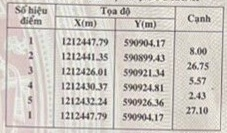

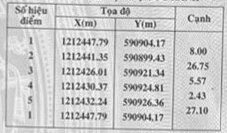

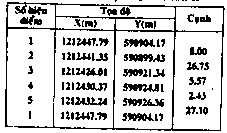

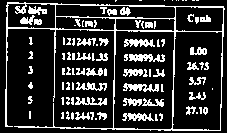

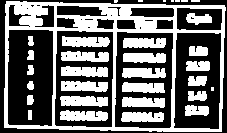

In [ ]:
table_img = cv2.imread(image)
cv2_imshow(table_img)
for i in [gray,thresh,invert,dilate]:
  cv2_imshow(i)

array([[210, 194, 200, ..., 206, 218, 215],
       [221, 201, 197, ..., 214, 221, 219],
       [226, 214, 201, ..., 209, 213, 212],
       ...,
       [219, 218, 224, ..., 224, 224, 218],
       [221, 212, 223, ..., 226, 221, 212],
       [225, 213, 222, ..., 229, 229, 230]], dtype=uint8)
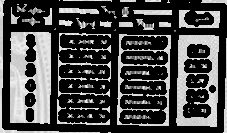

In [ ]:
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_all_contours = gray.copy()
cv2.drawContours(image_with_all_contours, contours, -1, (0, 255, 0), 3)

array([[210, 194, 200, ..., 206, 218, 215],
       [221, 201, 197, ..., 214, 221, 219],
       [226, 214, 201, ..., 209, 213, 212],
       ...,
       [219, 218, 224, ..., 224, 224, 218],
       [221, 212, 223, ..., 226, 221, 212],
       [225, 213, 222, ..., 229, 229, 230]], dtype=uint8)
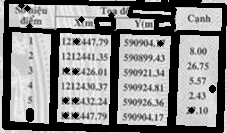

In [ ]:
rectangular_contours = []
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    if len(approx) == 4:
        rectangular_contours.append(approx)
image_with_only_rectangular_contours = gray.copy()
cv2.drawContours(image_with_only_rectangular_contours, rectangular_contours, -1, (0, 255, 0), 3)


array([[210, 194, 200, ..., 206, 218, 215],
       [221, 201, 197, ..., 214, 221, 219],
       [226, 214, 201, ..., 209, 213, 212],
       ...,
       [219, 218, 224, ..., 224, 224, 218],
       [221, 212, 223, ..., 226, 221, 212],
       [225, 213, 222, ..., 229, 229, 230]], dtype=uint8)
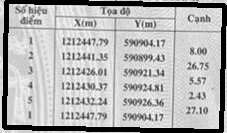

In [ ]:
max_area = 0
contour_with_max_area = None
for contour in rectangular_contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        contour_with_max_area = contour
image_with_contour_with_max_area = gray.copy()
cv2.drawContours(image_with_contour_with_max_area, [contour_with_max_area], -1, (0, 255, 0), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
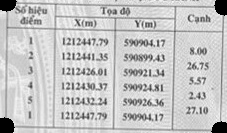

In [ ]:
def order_points(pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        
        s = pts.sum(axis=1)
        
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
contour_with_max_area_ordered = order_points(contour_with_max_area)
image_with_points_plotted = gray.copy()
for point in contour_with_max_area_ordered:
    point_coordinates = (int(point[0]), int(point[1]))
    image_with_points_plotted = cv2.circle(image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)
image_with_points_plotted

In [ ]:
def calculateDistanceBetween2Points(p1, p2):
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

In [ ]:
existing_image_width = gray.shape[1]
existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
distance_between_top_left_and_top_right = calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[1])
distance_between_top_left_and_bottom_left = calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[3])
aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
new_image_width = existing_image_width_reduced_by_10_percent
new_image_height = int(new_image_width * aspect_ratio)

array([[208, 210, 208, ..., 191, 201, 211],
       [203, 174, 164, ..., 173, 173, 171],
       [192, 150, 160, ..., 181, 164, 135],
       ...,
       [226, 174, 178, ..., 225, 233, 164],
       [220, 162, 156, ..., 199, 198, 148],
       [227, 174, 157, ..., 166, 165, 156]], dtype=uint8)
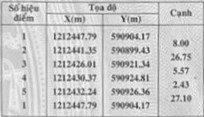

In [ ]:
pts1 = np.float32(contour_with_max_area_ordered)
pts2 = np.float32([[0, 0], [new_image_width, 0], [new_image_width, new_image_height], [0, new_image_height]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
perspective_corrected_image = cv2.warpPerspective(gray, matrix, (new_image_width, new_image_height))
perspective_corrected_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
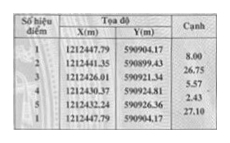

In [ ]:
# thêm padding
image_height = gray.shape[0]
padding = int(image_height * 0.1)
perspective_corrected_image_padded = cv2.copyMakeBorder(perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
perspective_corrected_image_padded

# B: Xóa đường kẻ của bảng

In [18]:
# class linesRemover:

#   def __init__(self, image):
#     self.image = image
#     # self.image = cv2.imread(image)

#   def grayscale_image(self):
#     self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

#   def threshold_image(self):
#       self.thresholded_image = cv2.threshold(self.grey, 127, 255, cv2.THRESH_BINARY)[1]

#   def invert_image(self):
#       self.inverted_image = cv2.bitwise_not(self.thresholded_image)

In [19]:
grey_tb = process_img
thresh_tb = cv2.threshold(grey_tb, 180, 255, cv2.THRESH_BINARY)[1] # chỉnh 180
invert_tb = cv2.bitwise_not(thresh_tb)
for i in [grey_tb,thresh_tb,invert_tb]:
  cv2_imshow(i)

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'threshold'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
# grey_tb = cv2.bitwise_not(grey_tb)
# bw = cv2.adaptiveThreshold(grey_tb, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
# hor = np.copy(invert_tb)
# hor

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
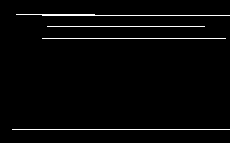

In [ ]:
# đọc Morphology Operations: https://docs.opencv.org/4.x/dd/dd7/tutorial_morph_lines_detection.html
hor = np.array([[1,1,1,1,1,1]])
# hor = np.copy(invert_tb)
vertical_lines_eroded_image = cv2.erode(invert_tb, hor, iterations=6)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=15)
vertical_lines_eroded_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
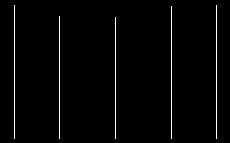

In [ ]:
ver = np.array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
horizontal_lines_eroded_image = cv2.erode(invert_tb, ver, iterations=2)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=5)
horizontal_lines_eroded_image

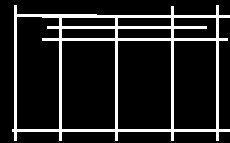

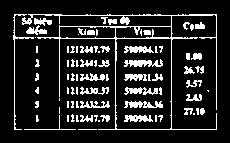

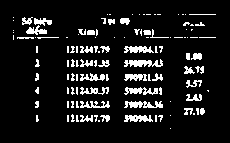

In [ ]:
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=2)
image_without_lines = cv2.subtract(invert_tb, combined_image_dilated)

cv2_imshow(combined_image_dilated)
cv2_imshow(invert_tb)
cv2_imshow(image_without_lines)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
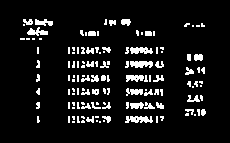

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
image_without_lines_noise_removed = cv2.erode(image_without_lines, kernel, iterations=1)
image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)
image_without_lines_noise_removed

# C: Vẽ boundingbox và crop ảnh


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
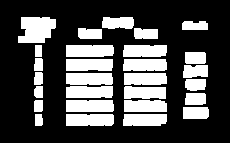

In [ ]:
kernel_to_remove_gaps_between_words = np.array([
            [1,1],
            [1,1]
    ])
dilated_image = cv2.dilate(image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=1)
simple_kernel = np.ones((5,5), np.uint8)
dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=1)
# cv2_imshow(dilated_image)
dilated_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
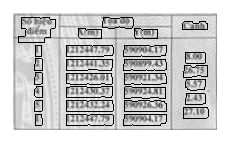

In [ ]:
result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = result[0]
image_with_contours_drawn = grey_tb.copy()
cv2.drawContours(image_with_contours_drawn, contours, -1, (0, 255, 0), 1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
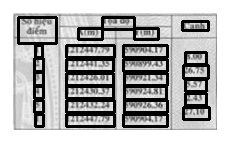

In [ ]:
bounding_boxes = []
image_with_all_bounding_boxes = grey_tb.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, w, h))
    image_with_all_bounding_boxes = cv2.rectangle(image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
image_with_all_bounding_boxes

In [ ]:
bounding_boxes

[(4, 1, 222, 131),
 (7, 29, 47, 98),
 (8, 4, 24, 23),
 (20, 4, 3, 3),
 (26, 7, 3, 3),
 (27, 95, 7, 10),
 (27, 81, 7, 9),
 (27, 65, 7, 10),
 (27, 50, 7, 10),
 (28, 110, 4, 10),
 (28, 36, 6, 10),
 (28, 25, 3, 3),
 (30, 4, 5, 4),
 (34, 4, 21, 24),
 (36, 4, 5, 3),
 (54, 30, 60, 98),
 (56, 17, 23, 12),
 (56, 5, 52, 12),
 (60, 110, 48, 11),
 (60, 96, 48, 11),
 (61, 81, 47, 11),
 (61, 66, 47, 11),
 (61, 51, 48, 11),
 (62, 36, 48, 11),
 (64, 114, 3, 3),
 (64, 99, 3, 3),
 (64, 84, 4, 4),
 (65, 69, 3, 3),
 (65, 54, 3, 4),
 (65, 39, 3, 4),
 (74, 114, 3, 3),
 (74, 99, 3, 3),
 (74, 84, 4, 4),
 (74, 70, 3, 3),
 (75, 54, 3, 4),
 (75, 40, 3, 3),
 (80, 18, 3, 3),
 (84, 18, 10, 3),
 (87, 26, 4, 3),
 (96, 18, 19, 12),
 (107, 6, 15, 11),
 (110, 14, 3, 3),
 (114, 31, 60, 98),
 (114, 0, 4, 3),
 (116, 19, 21, 11),
 (121, 112, 43, 10),
 (122, 97, 43, 11),
 (122, 82, 43, 11),
 (122, 68, 44, 10),
 (123, 53, 43, 10),
 (123, 38, 43, 10),
 (129, 7, 46, 11),
 (138, 0, 5, 2),
 (139, 26, 3, 4),
 (144, 19, 10, 3),
 (1

In [ ]:
bounding_boxes.sort(key = lambda x: x[0])

In [ ]:
def display_img(image, x, y, w, h):
  cropped_image = image[y:y+h, x:x+w]

  plt.imshow(cropped_image)
  plt.show()
  return cropped_image

In [ ]:
save_dir = '/content/drive/MyDrive/OCR/Cropped_Image'

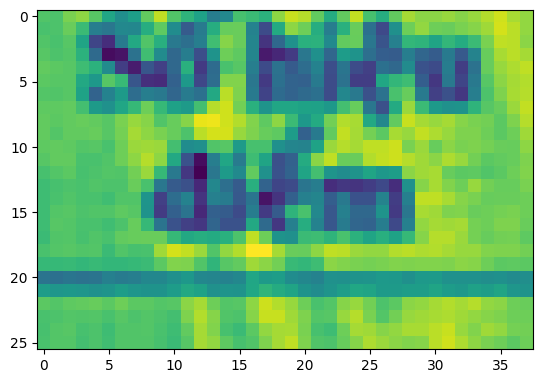

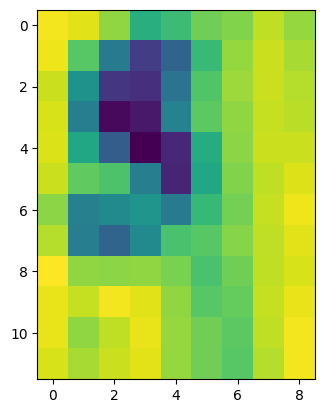

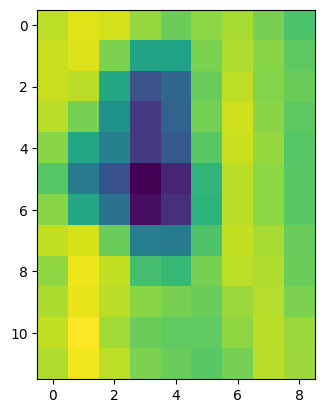

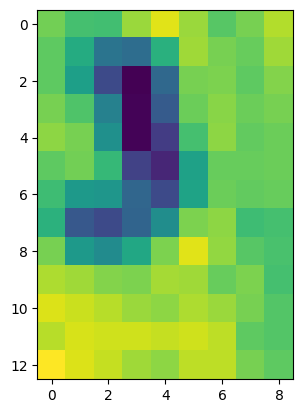

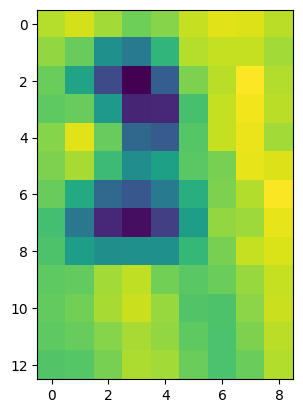

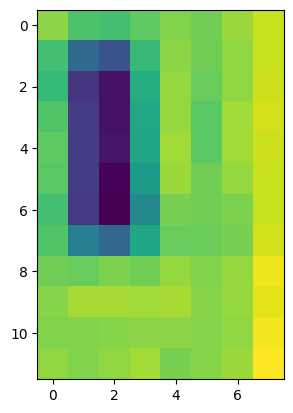

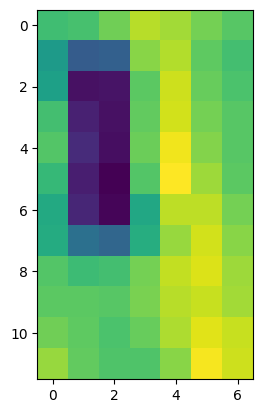

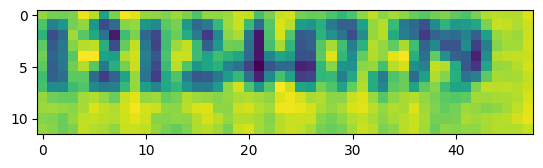

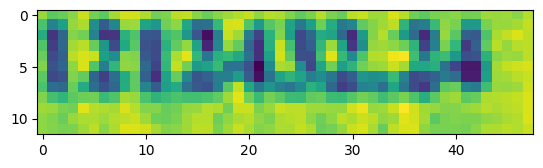

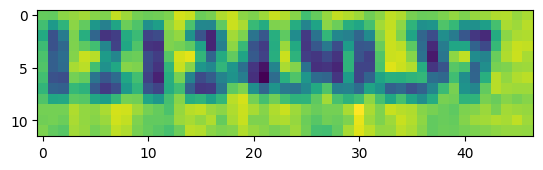

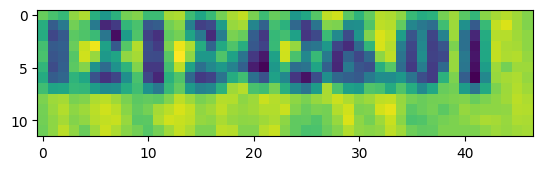

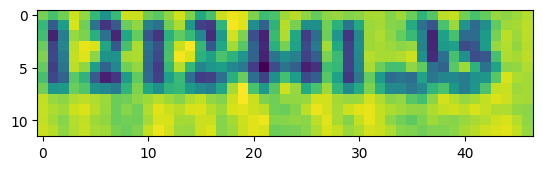

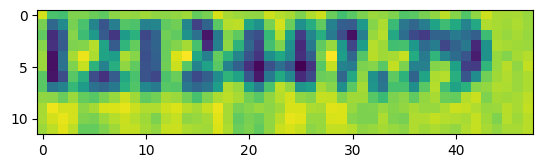

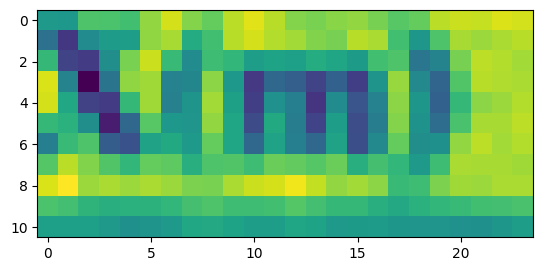

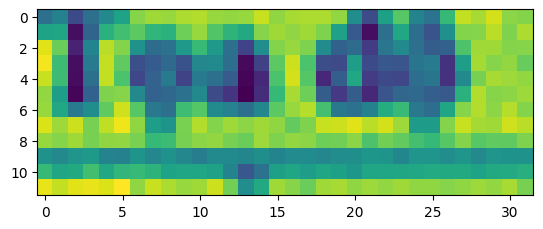

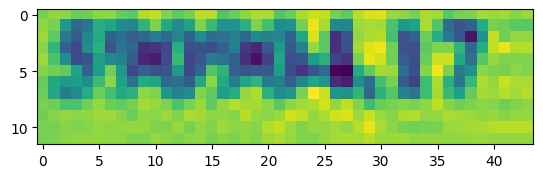

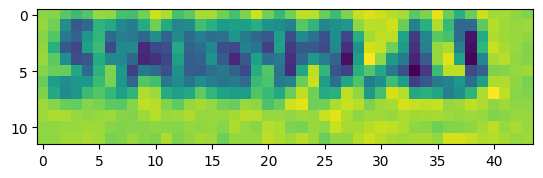

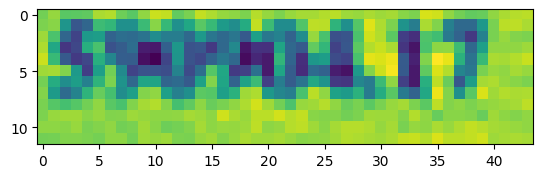

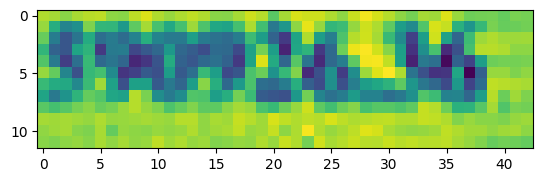

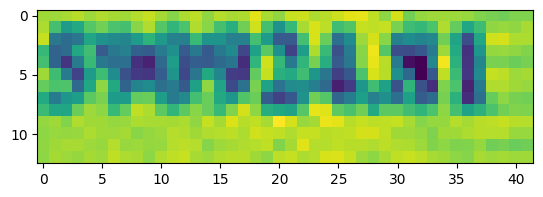

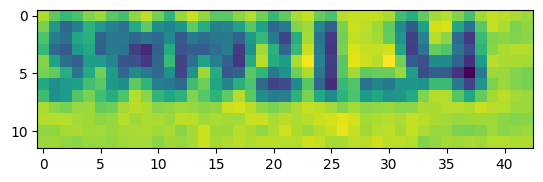

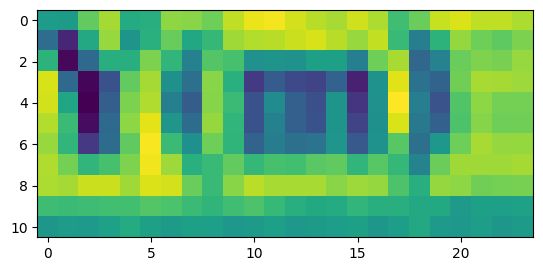

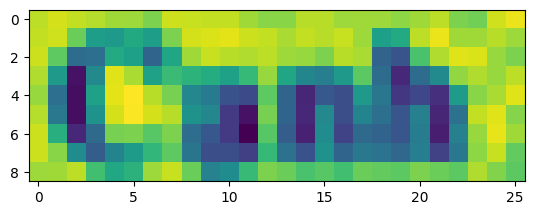

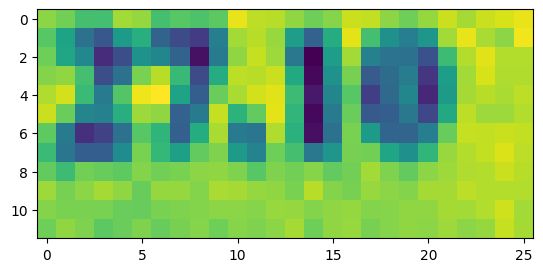

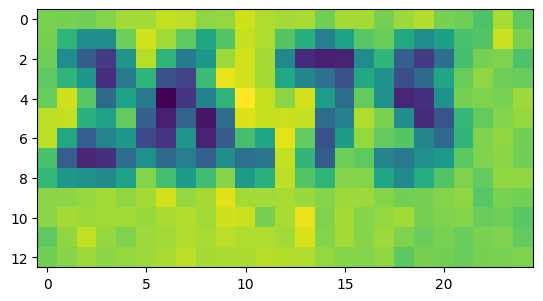

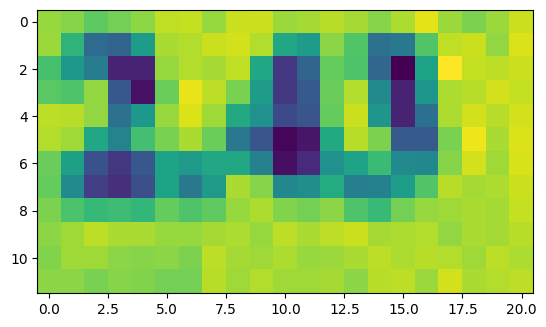

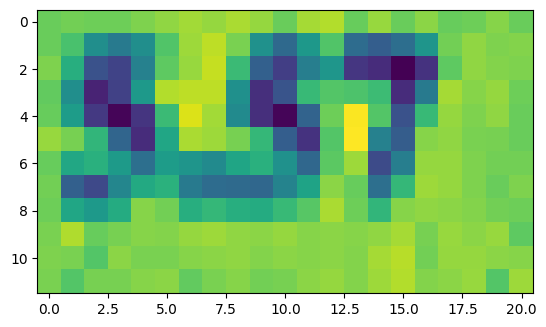

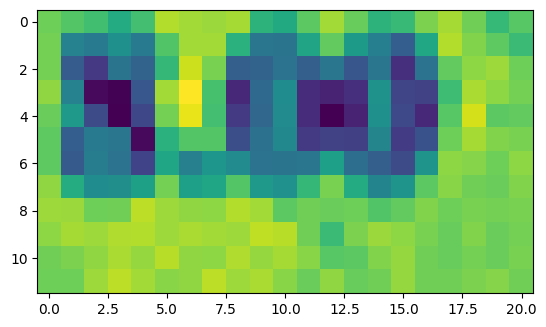

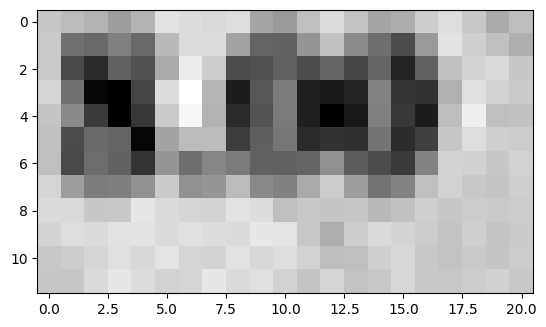

In [ ]:
import os
for idx, i in enumerate(bounding_boxes):
  cropped = display_img(grey_tb, i[0], i[1], i[2], i[3])
  cropped_image_path = os.path.join(save_dir, f'table_{idx + 1}.jpg')
  cv2.imwrite(cropped_image_path, cropped)
  plt.imshow(cropped, cmap = 'gray')
  # print(i[0],i[1],i[2],i[3])